In [1]:
import os, random, matplotlib, pickle, yaml
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
from glob2 import glob
from sklearn.utils import shuffle


SMALL_SIZE, MEDIUM_SIZE = 9, 12

In [2]:
result_path = "results/round2_legs_antennae_resnet101"
with open(f"{result_path}/INFO.yaml") as f:
    INFO = yaml.load(f, Loader=yaml.FullLoader)
    INFO_values = list(INFO.values())
    INFO_values.sort(key=lambda x: x['order'])
    
config_path = "."
with open(f"{config_path}/config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [3]:
tot_bp, tot_bp_scaled, tot_bp_rotated, tot_body_orientation, tot_angles, tot_rotations, tot_power, tot_embed = [], [], [], [], [], [], [], []
for file in tqdm(INFO_values):
    tot_bp.append( np.load(f"{file['directory']}/bodypoints.npy") )
    tot_bp_scaled.append( np.load(f"{file['directory']}/scaled_bodypoints.npy") )
    tot_bp_rotated.append( np.load(f"{file['directory']}/rotated_bodypoints.npy") )
    tot_body_orientation.append( np.load(f"{file['directory']}/body_orientation_angles.npy") )
    tot_angles.append( np.load(f"{file['directory']}/angles.npy") )
    tot_power.append( np.load(f"{file['directory']}/power.npy") )
    tot_embed.append( np.load(f"{file['directory']}/embeddings.npy") )

tot_bp = np.concatenate(tot_bp)
tot_bp_scaled = np.concatenate(tot_bp_scaled)
tot_bp_rotated = np.concatenate(tot_bp_rotated)
tot_body_orientation = np.concatenate(tot_body_orientation)
tot_angles = np.concatenate(tot_angles)
tot_power = np.concatenate(tot_power, axis=2)
tot_embed = np.concatenate(tot_embed)

<hr>
<hr>

In [5]:
import hdbscan

In [6]:
num_fr, _ = tot_embed.shape
samp_idx = random.sample(range(num_fr), int(num_fr*10/10))
print(len(samp_idx))

test_embed = tot_embed[samp_idx, :]

1000781


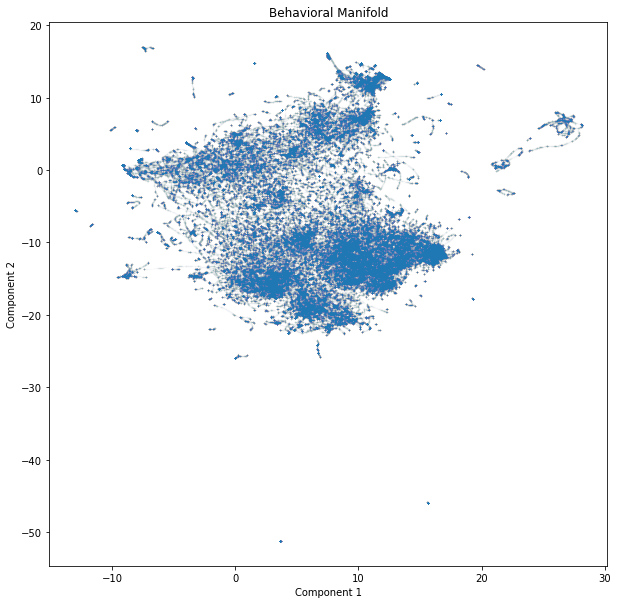

In [6]:
fig_base, ax_base = plt.subplots(figsize=(10,10))
ax_base.scatter(test_embed[:,0], test_embed[:,1], alpha=0.008, s=1)  
ax_base.set(xlabel='Component 1', ylabel='Component 2', title="Behavioral Manifold")
plt.show()

In [7]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2000, 
                            min_samples=20,
                            cluster_selection_epsilon=0,#1/17
                            cluster_selection_method="eom",
                            memory="memory"
                           ).fit(test_embed[:,:-1])

In [8]:
# parameters
num_clusters = np.max(clusterer.labels_)+1
outlier_pts = (clusterer.labels_ == -1)
labeled_pts = (clusterer.labels_ != -1)

print(f"Frac Outlier: {len(np.where(outlier_pts)[0])/len(clusterer.labels_)}")
print(f"# Clusters: {num_clusters}")

# cmap: coloring
color_palette = sns.color_palette('rainbow', num_clusters)
color_palette = shuffle(color_palette)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = np.array([sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)])

Frac Outlier: 0.3458309060623653
# Clusters: 69


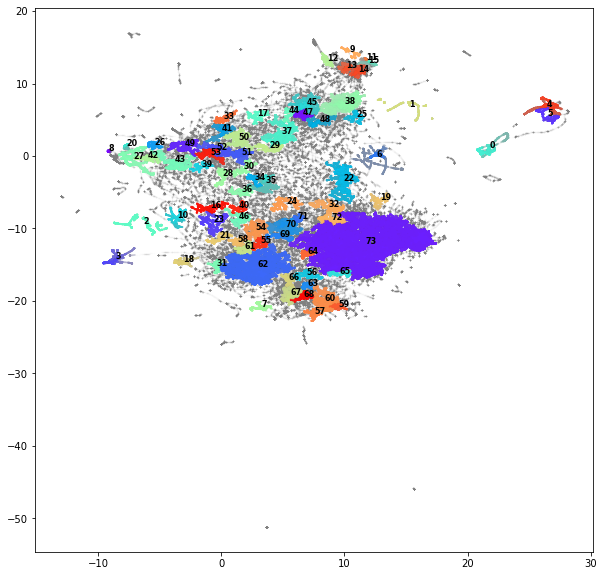

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

# cluster colors
ax.scatter(test_embed[outlier_pts,0], test_embed[outlier_pts,1], 
           c="gray", s=1, alpha=0.01)
ax.scatter(test_embed[labeled_pts,0], test_embed[labeled_pts,1], 
           c=cluster_member_colors[labeled_pts], s=1, alpha=0.2)

# numbering
cluster_mean = []
for i in tqdm(range(num_clusters)):
    idx = (clusterer.labels_==i)
    ax.annotate(i, np.mean(test_embed[idx,:-1], axis=0), fontsize=8, fontweight='bold')
    cluster_mean.append(np.mean(test_embed[idx,:-1], axis=0).tolist())
cluster_mean = np.array(cluster_mean)

plt.show()

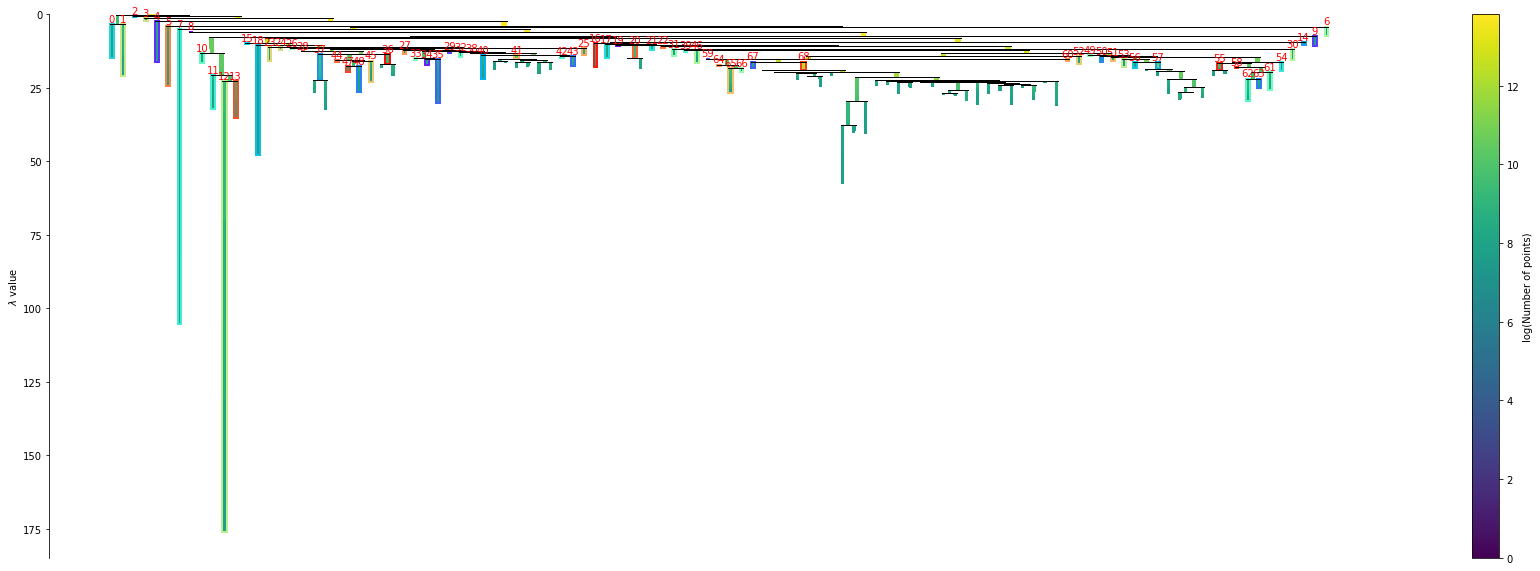

In [9]:
fig, ax = plt.subplots(figsize=(30,10))
# ax.set(ylim=(0,35))
clusterer.condensed_tree_.plot(leaf_separation=2,
                               label_clusters=True,
                               log_size=True,
                               select_clusters=True,
                               selection_palette=color_palette,
                              axis=ax)

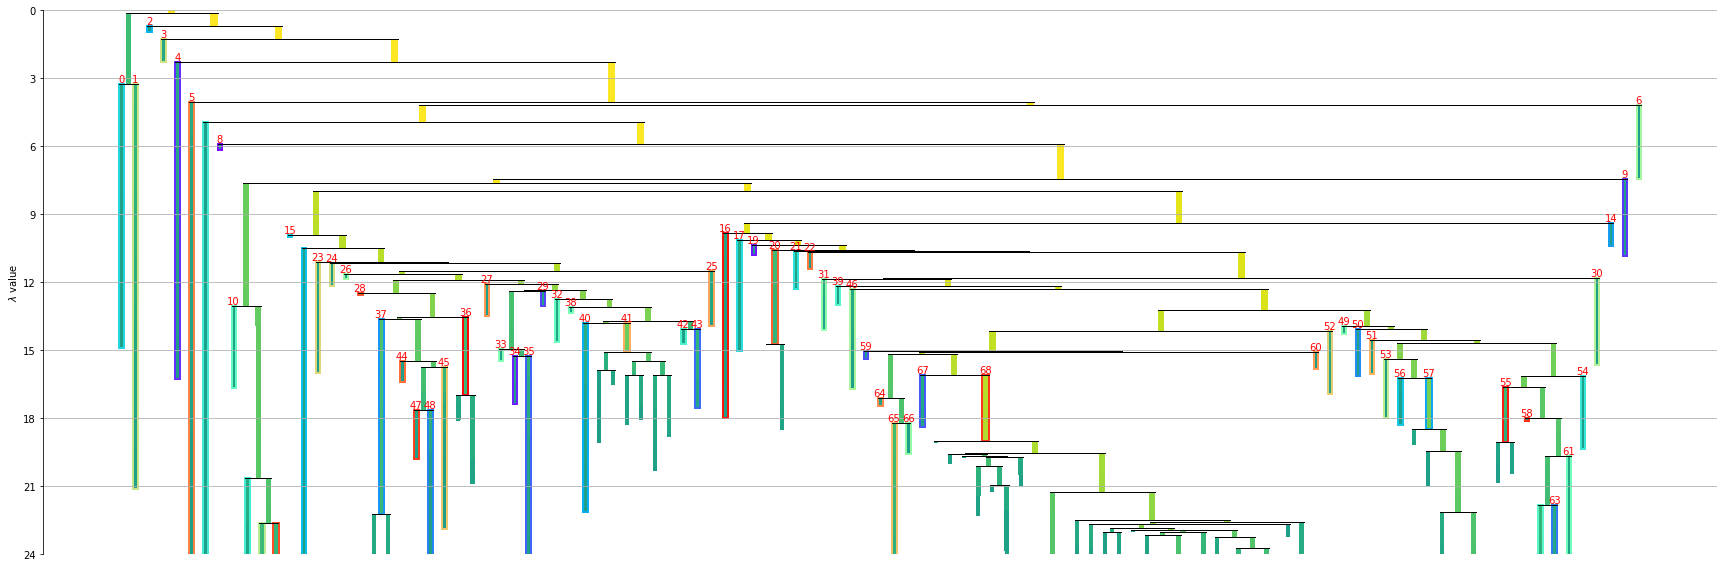

In [12]:
fig, ax = plt.subplots(figsize=(30,10))
ax.set(ylim=(0,24), yticks=np.arange(0,25,3))
clusterer.condensed_tree_.plot(leaf_separation=2,
                               label_clusters=True,
                               log_size=True,
                               colorbar=False,
                               select_clusters=True,
                               selection_palette=color_palette,
                              axis=ax)
ax.grid(axis='y')